<a href="https://colab.research.google.com/github/nrzsdy1993/Deeplearning_Basic/blob/main/20211101_face_detection_DSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
! git clone https://github.com/yebiny/Face-detection-for-DSM.git

fatal: destination path 'Face-detection-for-DSM' already exists and is not an empty directory.


In [10]:
! git clone https://github.com/prajnasb/observations.git

fatal: destination path 'observations' already exists and is not an empty directory.


In [11]:
import cv2, sys
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [12]:
def detect_flow(imgPath, modelDir):
    
    # read image
    img = cv2.imread(imgPath)
    (img_h, img_w) = img.shape[:2]
    print("* org img shape:", imgPath,  img.shape)
    
    # use model
    facenet = cv2.dnn.readNet(modelDir+"/deploy.prototxt",
                              modelDir+"/res10_300x300_ssd_iter_140000.caffemodel")
    
    blob = cv2.dnn.blobFromImage( img, 
                                  1.0, (300, 300),
    	                          (104.0, 177.0, 123.0))
    facenet.setInput(blob)
    detections = facenet.forward()
    print("* dections results:", detections.shape)
   
    # get results from detections
    for i in range(detections.shape[2]):
      conf = detections[0,0,i,2]
      if conf <0.5:
        continue
      x1 = int(detections[0,0,i,3]*img_w)
      y1 = int(detections[0,0,i,4]*img_h)
      x2 = int(detections[0,0,i,5]*img_w)
      y2 = int(detections[0,0,i,6]*img_h)
      cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    
    # visualize
    cv2_imshow(img)


* org img shape: Face-detection-for-DSM/imgs/person.jpeg (745, 875, 3)
* dections results: (1, 1, 200, 7)


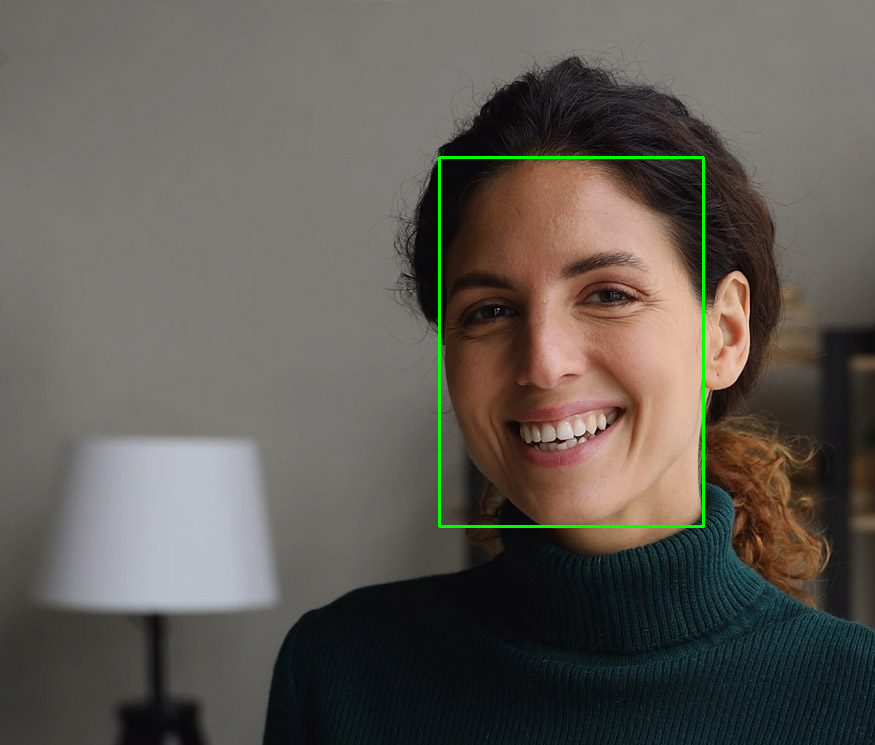

In [13]:
imgPath = 'Face-detection-for-DSM/imgs/person.jpeg'
modelDir = 'Face-detection-for-DSM/models'
detect_flow(imgPath,modelDir)


# Classification

In [14]:
from imutils import paths
import sys, os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import applications, utils, layers, models, optimizers
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [15]:
def load_datasets(dataDir):
    print("[INFO] Load Datasets...")
    imagePaths = list(paths.list_images(dataDir))

    data = []
    labels = []
    for imagePath in imagePaths:
    	# extract the class label from the filename
    	label = imagePath.split(os.path.sep)[-2]
        #print(label)
    
    	# load the input image (224x224) and preprocess it
    	image = load_img(imagePath, target_size=(224, 224))
    	image = img_to_array(image)
    	image = applications.mobilenet_v2.preprocess_input(image)
    	# update the data and labels lists, respectively
    	data.append(image)
    	labels.append(label)
    
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    labels = utils.to_categorical(labels)
    
    data = np.array(data, dtype="float32")
    labels = np.array(labels)
    print('* data shape:',data.shape, labels.shape)
    
    
    # the data for training and the remaining 20% for testing
    (trainX, testX, trainY, testY) = train_test_split(data, labels,
                                     test_size=0.20, stratify=labels, random_state=42)
    print('* splited data shape:',trainX.shape, testX.shape, trainY.shape, testY.shape)

    return trainX, testX, trainY, testY

In [16]:
! ls observations

experiements  mask_classifier  README.md


In [17]:
dataDir = 'observations/experiements/data'
trainX, testX, trainY, testY = load_datasets(dataDir)

[INFO] Load Datasets...
* data shape: (1376, 224, 224, 3) (1376, 2)
* splited data shape: (1100, 224, 224, 3) (276, 224, 224, 3) (1100, 2) (276, 2)


In [18]:
def train_model( trainX, testX, trainY, testY,
                 EPOCHS=1, 
                 INIT_LR=1e-4, 
                 BS=32):

    print("[INFO] Build  Model ...")
    base_model = applications.MobileNetV2( weights="imagenet", 
                                           include_top=False,
    	                                   input_tensor=layers.Input(shape=(224, 224, 3)))
    
    y = base_model.output
    y = layers.AveragePooling2D(pool_size=(7, 7))(y)
    y = layers.Flatten(name="flatten")(y)
    y = layers.Dense(128, activation="relu")(y)
    y = layers.Dropout(0.5)(y)
    y = layers.Dense(2, activation="softmax")(y)
    
    model = models.Model(inputs=base_model.input, outputs=y)
    for layer in base_model.layers:
    	layer.trainable = False
    

    # compile our model
    print("[INFO] Compiling  Model ...")
    opt = optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


    # construct the training image generator for data augmentation
    aug = ImageDataGenerator( rotation_range=20,
    	                      zoom_range=0.15,
    	                      width_shift_range=0.2,
    	                      height_shift_range=0.2,
    	                      shear_range=0.15,
    	                      horizontal_flip=True,
    	                      fill_mode="nearest")

    # train the head of the network
    print("[INFO] Training  Model ...")
    history = model.fit( aug.flow(trainX, trainY, batch_size=BS),
	               steps_per_epoch=len(trainX) // BS,
	               validation_data=(testX, testY),
	               validation_steps=len(testX) // BS,
	               epochs=EPOCHS)

    return history, model

In [20]:
histroy, model = train_model(trainX,testX,trainY,testY ,EPOCHS = 2)

[INFO] Build  Model ...
[INFO] Compiling  Model ...
[INFO] Training  Model ...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/2
34/34 [==============================] - 50s 1s/step - loss: 0.6248 - accuracy: 0.7135 - val_loss: 0.3072 - val_accuracy: 0.9565
Epoch 2/2
34/34 [==============================] - 46s 1s/step - loss: 0.2621 - accuracy: 0.9494 - val_loss: 0.1561 - val_accuracy: 0.9674


In [21]:
#저장하는 코드
model.save('my_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
